## Setting up Project and Downloading Data

In [1]:
#!pip list
#!nvidia-smi
!pip3 install keras==2.2.5 nibabel==2.3.3 numpy==1.17.5 matplotlib==3.1.2 --user
!pip3 install --upgrade tensorflow --user
#!pip3 install -U keras-tuner --user

    100% |████████████████████████████████| 337kB 17.5MB/s ta 0:00:01
    100% |████████████████████████████████| 3.2MB 13.1MB/s ta 0:00:01
    100% |████████████████████████████████| 20.0MB 2.4MB/s eta 0:00:01
    100% |████████████████████████████████| 13.1MB 3.6MB/s eta 0:00:01    99% |████████████████████████████████| 13.1MB 48.4MB/s eta 0:00:01
    100% |████████████████████████████████| 2.9MB 13.5MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 25.8MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 28.2MB/s ta 0:00:01
  Stored in directory: /home/ec2-user/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built bz2file
coremltools 2.0 has requirement six==1.10.0, but you'll have six 1.13.0 which is incompatible.
  The scripts f2py, f2py3 and f2py3.6 are installed in '/home/ec2-user/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-war

In [80]:
run_on_first_half = True
#from kerastuner import HyperModel
#import kerastuner as kt
import numpy as np
import math
from matplotlib import pyplot as plt
import nibabel as nib
import numpy as np
import random
import os
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1
#os.environ["CUDA_VISIBLE_DEVICES="]='-1'
import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow import image 
from tensorflow import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from google.colab import drive
#drive.mount("/content/gdrive")

### Utility Functions for Filtering and Plotting Predictions

In [ ]:
def filter_tumor_labels(labels=None):
    zerocheck = np.any(labels, axis=(1, 2)).flatten()
    tumor_indices = np.where(zerocheck==True)
    healthy_indices = np.where(zerocheck==False)
    #nontumors = labels[res2 == False]
    #tumors = labels[res2 == True]
    tumor_labels = labels[tumor_indices]
    return tumor_labels


def tumor_filter(features=None,labels=None):
    zerocheck = np.any(labels, axis=(1, 2)).flatten()
    tumor_indices = np.where(zerocheck==True)
    tumor_features = features[tumor_indices]
    tumor_labels = labels[tumor_indices]
    if tumor_features.shape[0]!=tumor_labels.shape[0]:
        print("Shapes of tumor filtering are messed up!")
    return tumor_features,tumor_labels

    
def plot_predictions(predictions,labels):
    fix, ax = plt.subplots(maxplots,2, figsize=(8,20))
    for i in range(len(predictions)):
        ax[i,0].imshow(labels[i,:,:,0])
        ax[i,1].imshow(trainpredictions[i,:,:,0])
        if i == maxplots:
            break

    plt.show()

#d,b = data_dictionary.get("tumor_features"),data_dictionary.get("tumor_labels")
#print(d.shape)
#plot_predictions(trainpredictions)
#d1,b1 = tumor_filter(d,b)
#print(d1.shape)
#plt.imshow(b1[10,:,:,0])

In [3]:


ROOT = "/content/gdrive/My Drive"
DATA = os.path.join(ROOT,"data")
MODEL = os.path.join(ROOT,"model")
#model_path = os.path.join(MODEL,'u_net_braintumor_all_slices_augmented.h5')

!ls $DATA/"test"

#!mkdir  /content/gdrive/My\ Drive/data
#!unzip ZebsyxKkZiQcaXtMgre1.zip -d /content/gdrive/My\ Drive/
#!mkdir $MODEL
#!wget https://tdsassignment.s3-eu-west-1.amazonaws.com/ZebsyxKkZiQcaXtMgre1.zip
#!unzip ZebsyxKkZiQcaXtMgre1.zip
#!ls data

ls: cannot access '/content/gdrive/My': No such file or directory
ls: cannot access 'Drive/data/test': No such file or directory


### Utility Functions for Various Purposes

In [2]:
def binary_shaper(predictions,threshold):
    test_masks = np.empty_like(predictions)
    test_masks[np.where( predictions > threshold )] = 1
    test_masks[np.where( predictions <= threshold )] = 0
    return test_masks

def dice_coef_2_lean(y_true, y_pred, smooth=K.epsilon()):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    denominator = K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth
    return (2. * intersection + smooth) / denominator

def dice_loss(y_true,y_pred): # this is differentiable
    """Dice Loss Implementation with squares"""
    return 1-dice_coef_2_lean(y_true, y_pred)

def vis(arr,i):
    plt.imshow(arr[i,:,:,0])
    plt.show()
    
def tumor_filter(features=None,labels=None):
    zerocheck = np.any(labels, axis=(1, 2)).flatten()
    tumor_indices = np.where(zerocheck==True)
    tumor_features = features[tumor_indices]
    tumor_labels = labels[tumor_indices]
    if tumor_features.shape[0]!=tumor_labels.shape[0]:
        print("Shapes of tumor filtering are messed up!")
    return tumor_features,tumor_labels

def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), kernel_initializer="he_normal", padding="same")(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), kernel_initializer="he_normal",padding="same")(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), kernel_initializer="he_normal", padding="same")(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(start_neurons * 2, (3, 3), kernel_initializer="he_normal", padding="same")(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), kernel_initializer="he_normal", padding="same")(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), kernel_initializer="he_normal", padding="same")(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), kernel_initializer="he_normal",  padding="same")(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(start_neurons * 8, (3, 3), kernel_initializer="he_normal", padding="same")(conv4)
    conv4 = BatchNormalization()(conv4)

    pool4 = MaxPooling2D((2, 2))(conv4)
    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), kernel_initializer="he_normal", padding="same")(pool4)
    convm = BatchNormalization()(convm)
    convm = Conv2D(start_neurons * 16, (3, 3), kernel_initializer="he_normal", padding="same")(convm)
    convm = BatchNormalization()(convm)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), kernel_initializer="he_normal", strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])

    uconv4 = Conv2D(start_neurons * 8, (3, 3), kernel_initializer="he_normal", padding="same")(uconv4)
    uconv4 = BatchNormalization()(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), kernel_initializer="he_normal", padding="same")(uconv4)
    uconv4 = BatchNormalization()(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), kernel_initializer="he_normal",strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])

    uconv3 = Conv2D(start_neurons * 4, (3, 3), kernel_initializer="he_normal", padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), kernel_initializer="he_normal", padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), kernel_initializer="he_normal", strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])

    uconv2 = Conv2D(start_neurons * 2, (3, 3),  kernel_initializer="he_normal",padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), kernel_initializer="he_normal", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3),kernel_initializer="he_normal", strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])

    uconv1 = Conv2D(start_neurons * 1, (3, 3), kernel_initializer="he_normal", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), kernel_initializer="he_normal",padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)

    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    model = Model(inputs=[input_layer], outputs=[output_layer])

    return model
    
def patient_data_loader(data_path,p_idx,slices,iftrain=1):
  if iftrain==1:
    ml_type = "train"
  else :
    ml_type = "test"
    p_idx=p_idx+20
  sample_prefix = f'{data_path}/{ml_type}/{p_idx:04d}/{p_idx:04d}'
  sample_t1    = nib.load(sample_prefix + '_t1.nii').get_data()[:,:,0:slices]
  sample_t1gd  = nib.load(sample_prefix + '_t1Gd.nii').get_data()[:,:,0:slices]
  sample_t2    = nib.load(sample_prefix + '_t2.nii').get_data()[:,:,0:slices]
  sample_flair = nib.load(sample_prefix + '_flair.nii').get_data()[:,:,0:slices]
  if iftrain == 0:
    return [sample_t1,sample_t1gd,sample_t2,sample_flair]
  else:
    sample_gt    = nib.load(sample_prefix + '_GlistrBoost.nii').get_data()[:,:,0:slices]
  return [sample_t1,sample_t1gd,sample_t2,sample_flair,sample_gt]

def data_visualizer(data,slide):
  modalities = ['t1', 't1Gd', 't2', 'flair', 'GlistrBoost']
  fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
  for i, (scan, modality) in enumerate(zip(data, modalities)):
    ax[i].imshow(data[i][:, :, slide], cmap=plt.cm.bone)
    ax[i].set_title(modality,color = 'black')
  plt.show()

DATA = "data"

### Summary of Initial Trial Experiments

- Image Augmentation had a positive effect in some cases. Due to a technical reason, the ImageDataGenerator Training did not start with bigger datasets, so we use the `model.fit`` methodology instead.

- I have seen that if I compile a dataset with a higher ratio of tumors, then a model trained on this dataset will also have better performance on a dataset having a lot of tumors.


### Start here : Utilities for Patient Data Loading and Visualization

In [3]:
def ratio_(num=[],den=[],object_name="tumor labels",**kwargs):
    if kwargs.get("stringmode") is not None:
        len1=kwargs.get("len1")
        len_total=kwargs.get("len_total")
        print(f"The amount of {object_name} in the data is {np.round(100*len1/len_total,1)}%")
    else :
        print(f"The amount of {object_name} in the data is {np.round(100*len(num)/len(den),1)}%")

def data_producer(startpatient=1,endpatient=2,custom_patients=[1,2,3],data_path=DATA,need_patches=False,size_param=40,stride_param=40,slices=155,iftrain=1,balancing_mode="filter_tumor",**kwargs):
    if iftrain==1:
        print("loading data from train folder")
    else :
        print("loading data from test folder")
    strides = [1,stride_param,stride_param,1]
    sizes = [1,size_param,size_param,1]
    rates = [1, 1, 1, 1]
    """Data producer function to produce data for machine learniing. If balancing_mode=filter_tumor, 
    then additionally features and labels only corresponding to data containing tumor masks are produced"""
    patient_to_visualize = kwargs.get("visualize_patient")
    all_image_slices = [] 
    all_labels = []
    tumor_features = []
    tumor_labels = []
    tumor_label_patches = []
    tumor_feature_patches = []
    output = {}
    if custom_patients is None:
      patient_space=range(startpatient,endpatient)
    else:
      patient_space = custom_patients
    for p_idx in patient_space:
      print(f"Patient number {p_idx}")
      patient_features = np.empty((4, 240, 240,slices))
      patient_labels = np.empty((1,240,240,slices))
      patient_data = patient_data_loader(data_path,p_idx,slices,iftrain=iftrain) 
      if iftrain==1:
        features,labels = patient_data[:-1],patient_data[-1] # all scans for that patient loaded
      else :
        features = patient_data
      if p_idx==patient_to_visualize:
        slide = kwargs.get("slice_no")
        if slide >= slices:
          print("Decrease slide number! Program will throw an error!")
      if features[0].sum()!=0:
        patient_features[0:4,0:240,0:240,0:slices] = features
        #print(f"Shape of patient features is {patient_features.shape}")
        if iftrain == 1:
          patient_labels[0,0:240,0:240,0:slices] = labels
          all_labels.append(patient_labels)
        all_image_slices.append(patient_features)

        #print(len(all_image_slices))
      else:
        print("Anomaly happened, all values in image are 0!")
    if iftrain == 1:
      all_labels = np.concatenate(all_labels,axis=3).swapaxes(0,3)
      all_labels /= 255.0

    all_image_slices = np.concatenate(all_image_slices,axis=3).swapaxes(0,3) 
    all_image_slices /= 255.0
    if iftrain==1:
        tumor_features,tumor_labels = tumor_filter(all_image_slices,all_labels)
        print(tumor_labels.shape)
        print(tumor_features.shape)
        if need_patches == True and tumor_features.shape[0]==tumor_labels.shape[0]:
            #ratio_(num=tumor_labels,den=all_labels)
            tumor_label_patches = np.asarray(image.extract_patches(
            images=tumor_labels,
            sizes=sizes,
            strides=strides,
            rates=rates,
            padding="SAME",
            name="label_batches"),dtype=np.float32)
            print(f"The shape of tumor label patches after patching is {tumor_label_patches.shape}")

            feature_0_patches = np.asarray(image.extract_patches(
            images=tumor_features[:,:,:,0:1],
            sizes=sizes,
            strides=strides,
            rates=rates,
            padding="SAME",
            name="feature_batches0"),dtype=np.float32)

            feature_1_patches = np.asarray(image.extract_patches(
            images=tumor_features[:,:,:,1:2],
            sizes=sizes,
            strides=strides,
            rates=rates,
            padding="SAME",
            name="feature_batches1"),dtype=np.float32)

            feature_2_patches = np.asarray(image.extract_patches(
            images=tumor_features[:,:,:,2:3],
            sizes=sizes,
            strides=strides,
            rates=rates,
            padding="SAME",
            name="feature_batches2"),dtype=np.float32)

            feature_3_patches = np.asarray(image.extract_patches(
            images=tumor_features[:,:,:,3:4],
            sizes=sizes,
            strides=strides,
            rates=rates,
            padding="SAME",
            name="feature_batches3"),dtype=np.float32)

            feature_patches = np.stack([feature_0_patches,feature_1_patches,feature_2_patches,feature_3_patches],axis=4) # ,
            print(f"The shaape of feature patches after stacking is {feature_patches.shape}")
            print(f"Data Producer Complete")
            output = {"tumor_label_patches":tumor_label_patches,"tumor_feature_patches":feature_patches}
    output_add = {"all_features":all_image_slices,"all_labels":all_labels,"tumor_features":tumor_features,\
            "tumor_labels":tumor_labels}
    return {**output, **output_add}
    
         
    

## Generate Patches Data for Learning on Parallel Task

kwargs = {"visualize_patient":1,"slice_no":5}
patch_size=64
stride = patch_size//4

In [17]:
kwargs = {"visualize_patient":1,"slice_no":5}
patch_size=64
stride = patch_size//4
data_dictionary_first_half= data_producer(custom_patients=[1,2,5,6,7,8,9],startpatient=1,endpatient=10,need_patches=True,size_param = patch_size, stride_param=stride,slices=155,iftrain=1,**kwargs)
data_dictionary_first_half_test= data_producer(custom_patients=None,startpatient=3,endpatient=4+1,need_patches=True,size_param = patch_size, stride_param=stride,slices=155,iftrain=1,**kwargs)
data_dictionary_second_half= data_producer(custom_patients=None,startpatient=10,endpatient=20+1,need_patches=True,size_param = patch_size, stride_param=stride,slices=155,iftrain=1,**kwargs)

#fp = feature_patches.swapaxes(2,3).swapaxes(1,2).reshape(-1,11,11,4)
#lp = label_patches.swapaxes(2,3).swapaxes(1,2).reshape(-1,11,11,1)

loading data from train folder
Patient number 1
Patient number 2
Patient number 5
Patient number 6
Patient number 7
Patient number 8
Patient number 9
(464, 240, 240, 1)
(464, 240, 240, 4)
The shape of tumor label patches after patching is (464, 15, 15, 4096)
The shaape of feature patches after stacking is (464, 15, 15, 4096, 4)
Data Producer Complete


In [19]:
data_dictionary_first_half_test= data_producer(custom_patients=None,startpatient=3,endpatient=4+1,need_patches=True,size_param = patch_size, stride_param=stride,slices=155,iftrain=1,**kwargs)



loading data from train folder
Patient number 3
Patient number 4
(165, 240, 240, 1)
(165, 240, 240, 4)
The shape of tumor label patches after patching is (165, 15, 15, 4096)
The shaape of feature patches after stacking is (165, 15, 15, 4096, 4)
Data Producer Complete


## PREPARING PATCHES FOR 1ST HALF OF PATIENTTS

In [20]:
!#cat /proc/meminfo
run_on_first_half = True
run_on_first_half_test = True

if run_on_first_half == True:
    print(data_dictionary_first_half.keys())

    tumor_feature_patches1,tumor_label_patches1=data_dictionary_first_half.get("tumor_feature_patches"),data_dictionary_first_half.get("tumor_label_patches")

    fp1 = np.asarray(tumor_feature_patches1,dtype=np.float32).reshape(-1,patch_size,patch_size,4)
    lp1 = np.asarray(tumor_label_patches1,dtype=np.float32).reshape(-1,patch_size,patch_size,1)

if run_on_first_half_test == True:
    print(data_dictionary_first_half_test.keys())

    tumor_feature_patches1_test,tumor_label_patches1_test=data_dictionary_first_half_test.get("tumor_feature_patches"),data_dictionary_first_half_test.get("tumor_label_patches")

    fp1_test = np.asarray(tumor_feature_patches1_test,dtype=np.float32).reshape(-1,patch_size,patch_size,4)
    lp1_test = np.asarray(tumor_label_patches1_test,dtype=np.float32).reshape(-1,patch_size,patch_size,1)
    



dict_keys(['all_features', 'all_labels', 'tumor_features', 'tumor_labels', 'tumor_label_patches', 'tumor_feature_patches'])
dict_keys(['all_features', 'all_labels', 'tumor_features', 'tumor_labels', 'tumor_label_patches', 'tumor_feature_patches'])


### Creation of 2 Datasets : Dataset1 has less tumors, Dataset2 has more tumors

## Next We will Balance the Batches such that we have 30% of Batches without Tumors

In [21]:
def generate_tumor_healthy_indices(label_patches,ratio_healthy1=0.1):
    def generate_meta_label_batches(label_patches=None): 
        """Here we write a loop over all label_patches and save """
        df = np.zeros((len(label_patches),1),dtype=np.int)
        for i in range(label_patches.shape[0]):
            zerocheck = np.any(label_patches[i,:,:,0]) # axis=(1, 2)
            if zerocheck == True:
                df[i]=1
            else :
                df[i]=0
        return df

    df_meta = generate_meta_label_batches(label_patches=label_patches)
    tumor_patch_idx = np.where(df_meta==1)[0]
    healthy_patch_idx = np.where(df_meta==0)[0]
    #print(tumor_patch_idx)
    print(len(healthy_patch_idx)+len(tumor_patch_idx) == len(df_meta))


    ratio_healthy1 = ratio_healthy1
    #ratio_healthy2 = 0.1
    amount_tumor_patches = len(tumor_patch_idx)
    needed_healthy_patches_1 = np.int(ratio_healthy1*len(df_meta))
    #needed_healthy_patches_2 = np.int(ratio_healthy2*len(df_meta))
    healthy_patches_idx_1 = healthy_patch_idx[np.random.randint(len(healthy_patch_idx), size=(1, needed_healthy_patches_1))]
    #healthy_patches_idx_2 = healthy_patch_idx[np.random.randint(len(healthy_patch_idx), size=(1, needed_healthy_patches_2))]

    print(len(healthy_patches_idx_1[0])/len(df_meta)) # needed 30% healthy 
    #print(len(healthy_patches_idx_2[0])/len(df_meta)) # needed 10% healthy
    return np.concatenate([tumor_patch_idx,healthy_patches_idx_1[0]])

if run_on_first_half_test == True: 
    indices_to_use1 = generate_tumor_healthy_indices(label_patches=lp1,ratio_healthy1=0.3)


True
0.1


In [10]:
#print(f"Now we have {fp1.shape[0]} patches of mostly tumor data, now we proceed to machine learning part")

Now we have 141525 patches of mostly tumor data, now we proceed to machine learning part


In [ ]:
def savePickle(data, picklefile):
    """

    :param data: Data to be saved
    :param picklefile: Filename for output Pickle file, should have .pickle ending
    """
    import pickle
    with open(picklefile, "wb") as f:
        pickle.dump(data, f,protocol=4)
    f.close()

data_1_learning_path = os.path.join(DATA,"data_for_learning1.pkl")
#savePickle(data=data_for_learning1,picklefile=data_1_learning_path)
#tumor_70pc = {"fp":fp1,"lp":lp1}
#savePickle(tumor_70pc,"tumor70patches.pkl")
#tumor_90pc = {"fp":fp2,"lp":lp2}
#savePickle(tumor_90pc,"tumor90patches.pkl")

### Generating Machine Learning Splits on the Patches of Data
#### FIRST HALF

In [23]:
X_train1, y_train1, X_valid1,y_valid1  = fp1[indices_to_use1],lp1[indices_to_use1],fp1_test,lp1_test



We need to train a model that will perform tumor segmentation, then generate predictions on the test set.

That means that the final test predictions will be evaluated based on the average of the Dice scores computed over batches of size 155. 



### Defining the Dice Loss and Generator for Feeding the Data

In [24]:

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_coef_2_lean(y_true, y_pred, smooth=K.epsilon()):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    denominator = K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth
    return (2. * intersection + smooth) / denominator


def dice_loss(y_true,y_pred): # this is differentiable
    """Dice Loss Implementation with squares"""
    return 1-dice_coef_2_lean(y_true, y_pred)



### FIRST WE DO TRAINING ON THE PATCH TASK on FULL Data, Afterwards we will use these Weights to Fine-tune Training on the Intial Task

In [17]:
%%javascript
function ClickConnect(){ 
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click() 
} 
setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [30]:
#subsetsize_t = X_train.shape[0]//20
#subsetsize_v = X_valid.shape[0]//20
weights=None
SEED = 1
batch_size = 10
im_height = im_width = 64
epochs = 1
input_patch = Input((im_height, im_height,4), name='img')
#model_1_path = os.path.join(MODEL,'final_training_generator_1.h5')


#weights = model_1_path
howmanypatches = X_train1.shape[0]
steps_per_epoch = int(np.ceil(len(X_train1)//batch_size))
kwargs = {"epochs":epochs,"steps_per_epoch":steps_per_epoch,
                   "bs":batch_size,"model_path":"90_10_test_first_half.h5", "loss":dice_loss,
                   "start_neurons":32,"optimizer":optimizers.Adam()}
batch_size,epochs = kwargs["bs"],kwargs["epochs"]
model = build_model(input_patch, start_neurons=kwargs["start_neurons"])
model.compile(optimizer=kwargs["optimizer"], loss=kwargs["loss"],metrics=["binary_crossentropy"])
if weights is not None:
  model.load_weights(weights)
  


In [33]:
def training_main(ml_splits,weights=None,input_layer=None,**kwargs):
  [X_train,y_train,X_valid,y_valid] = ml_splits
  howmanypatches = X_train.shape[0]
  batch_size,epochs = kwargs["bs"],kwargs["epochs"]
  steps_per_epoch = int(np.ceil(len(X_train)//batch_size))
  model = build_model(input_layer, start_neurons=kwargs["start_neurons"])
  model.compile(optimizer=kwargs["optimizer"], loss=kwargs["loss"],metrics=["binary_crossentropy"])
  if weights is not None:
    model.load_weights(weights)
  print(f"Starting TRAINING ON {howmanypatches} patches!")
  callbacks = [EarlyStopping(patience=10, verbose=1),
              ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
              ModelCheckpoint(kwargs["model_path"], monitor='binary_crossentropy',verbose=1, 
                              save_best_only=True, save_weights_only=True)]
  results = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                              validation_data=(X_valid, y_valid),callbacks=callbacks)
  return {"model":model,"results":results}

output1= training_main(input_layer=input_patch,ml_splits = [X_train1, y_train1, X_valid1,y_valid1],**kwargs)

Starting TRAINING ON 30552 patches!
Train on 30552 samples, validate on 37125 samples
30550/30552 [============================>.] - ETA: 0s - loss: 0.1882 - binary_crossentropy: 1.6327
Epoch 00001: binary_crossentropy improved from inf to 1.63262, saving model to 90_10_test_first_half.h5
30552/30552 [==============================] - 3032s 99ms/sample - loss: 0.1882 - binary_crossentropy: 1.6326 - val_loss: 0.0440 - val_binary_crossentropy: 0.0029


Convergence NOTE : I HAVE SEEN THAT THE EFFICIENCY OF TRAINING (RATE OF LOSS DECREASE) is much faster with Small Batch size (10) compared to for example 155 that is the amount of brain slices per patient.

## Processing the 2nd Half of Patients

In [34]:
## We have data from 11 more patients to train and test on.
## So we will randomly pick 8 patients to train on and 3 patients out of the 11 remaining to test on.

second_batch_training_patients = 10 + np.random.choice(10,9,replace=False)
second_batch_testing_patients = [x for x in range(10,21) if x not in second_batch_training_patients]

print(f"The testing patients are {second_batch_training_patients}")
print(f"The training patients are {second_batch_testing_patients}")
data_dictionary_second_train= data_producer(custom_patients=second_batch_training_patients,need_patches=True,size_param = patch_size, stride_param=stride,slices=155,iftrain=1,**kwargs)


The testing patients are [19 18 17 14 12 10 11 15 13]
The training patients are [16, 20]
loading data from train folder
Patient number 19
Patient number 18
Patient number 17
Patient number 14
Patient number 12
Patient number 10
Patient number 11
Patient number 15
Patient number 13
(584, 240, 240, 1)
(584, 240, 240, 4)
The shape of tumor label patches after patching is (584, 15, 15, 4096)
The shaape of feature patches after stacking is (584, 15, 15, 4096, 4)
Data Producer Complete


## PREPARING PATCHES FOR 2ND HALF OF PATIENTS


In [36]:
## can be reshaped to # sizes[1], sizes[2], depth, where depth is images.shape[3]
run_on_first_half = False
data_dictionary_second_half = data_dictionary_second_train
if run_on_first_half == False:

  print(data_dictionary_second_half.keys())
  tumor_feature_patches2,tumor_label_patches2=data_dictionary_second_half.get("tumor_feature_patches"),data_dictionary_second_half.get("tumor_label_patches")

  #del data_dictionary_second_half
  fp2 = np.asarray(tumor_feature_patches2,dtype=np.float32).reshape(-1,patch_size,patch_size,4)
  lp2 = np.asarray(tumor_label_patches2,dtype=np.float32).reshape(-1,patch_size,patch_size,1)



dict_keys(['all_features', 'all_labels', 'tumor_features', 'tumor_labels', 'tumor_label_patches', 'tumor_feature_patches'])


In [27]:
#indices_to_use2 = generate_tumor_healthy_indices(label_patches=lp2)
from sklearn.model_selection import train_test_split
#X_train2,y_train2= fp2[indices_to_use2],lp2[indices_to_use2]
print(X_train2.shape)
if "data_dictionary_second_half" in locals():
  del data_dictionary_second_half
if "data_dictionary_second_train" in locals():
  del data_dictionary_second_train


(55698, 64, 64, 4)


NameError: ignored

In [37]:
data_dictionary_second_test= data_producer(custom_patients=second_batch_testing_patients,need_patches=True,size_param = patch_size, stride_param=stride,slices=155,iftrain=1,**kwargs)


loading data from train folder
Patient number 16
Patient number 20
(145, 240, 240, 1)
(145, 240, 240, 4)
The shape of tumor label patches after patching is (145, 15, 15, 4096)
The shaape of feature patches after stacking is (145, 15, 15, 4096, 4)
Data Producer Complete


In [38]:
## can be reshaped to # sizes[1], sizes[2], depth, where depth is images.shape[3]
run_on_first_half = False
if run_on_first_half == False:

  print(data_dictionary_second_test.keys())
  tumor_feature_patches3,tumor_label_patches3=data_dictionary_second_test.get("tumor_feature_patches"),data_dictionary_second_test.get("tumor_label_patches")

  #del data_dictionary_second_test
  fp3 = np.asarray(tumor_feature_patches3,dtype=np.float32).reshape(-1,patch_size,patch_size,4)
  lp3 = np.asarray(tumor_label_patches3,dtype=np.float32).reshape(-1,patch_size,patch_size,1)


dict_keys(['all_features', 'all_labels', 'tumor_features', 'tumor_labels', 'tumor_label_patches', 'tumor_feature_patches'])


In [39]:
indices_to_use2 = generate_tumor_healthy_indices(label_patches=lp2,ratio_healthy1=0.3)
X_train2,y_train2= fp2[indices_to_use2],lp2[indices_to_use2]
y_valid2 = lp3
X_valid2 = fp3
print(X_valid2.shape)
print(X_train2.shape)
print(y_valid2.shape)
print(y_train2.shape)

True
0.3
(32625, 64, 64, 4)
(66043, 64, 64, 4)
(32625, 64, 64, 1)
(66043, 64, 64, 1)


In [44]:
batch_size = 10
#weights =  os.path.join(MODEL,'final_training_generator_1.h5')
weights = "90_10_test_first_half.h5"
im_height = im_width = 64
epochs = 2
input_patch = Input((im_height, im_height,4), name='img')
#model_2_path = os.path.join(MODEL,"model_2_final_70.h5")
model_2_path = "model_2_final_70_imp.h5"
steps_per_epoch = int(np.ceil(len(X_train2)//batch_size))
kwargs = {"epochs":epochs,"steps_per_epoch":steps_per_epoch,
                   "bs":batch_size,"model_path":model_2_path, "loss":dice_loss,
                   "start_neurons":32,"optimizer":optimizers.Adam()}
#output2_realistic = training_main(weights=weights,input_layer=input_patch,ml_splits = [X_train2,y_train2,X_valid2,y_valid2],**kwargs)

####  Example of Training mid-Result for 1 Epoch on 2nd Part of Data
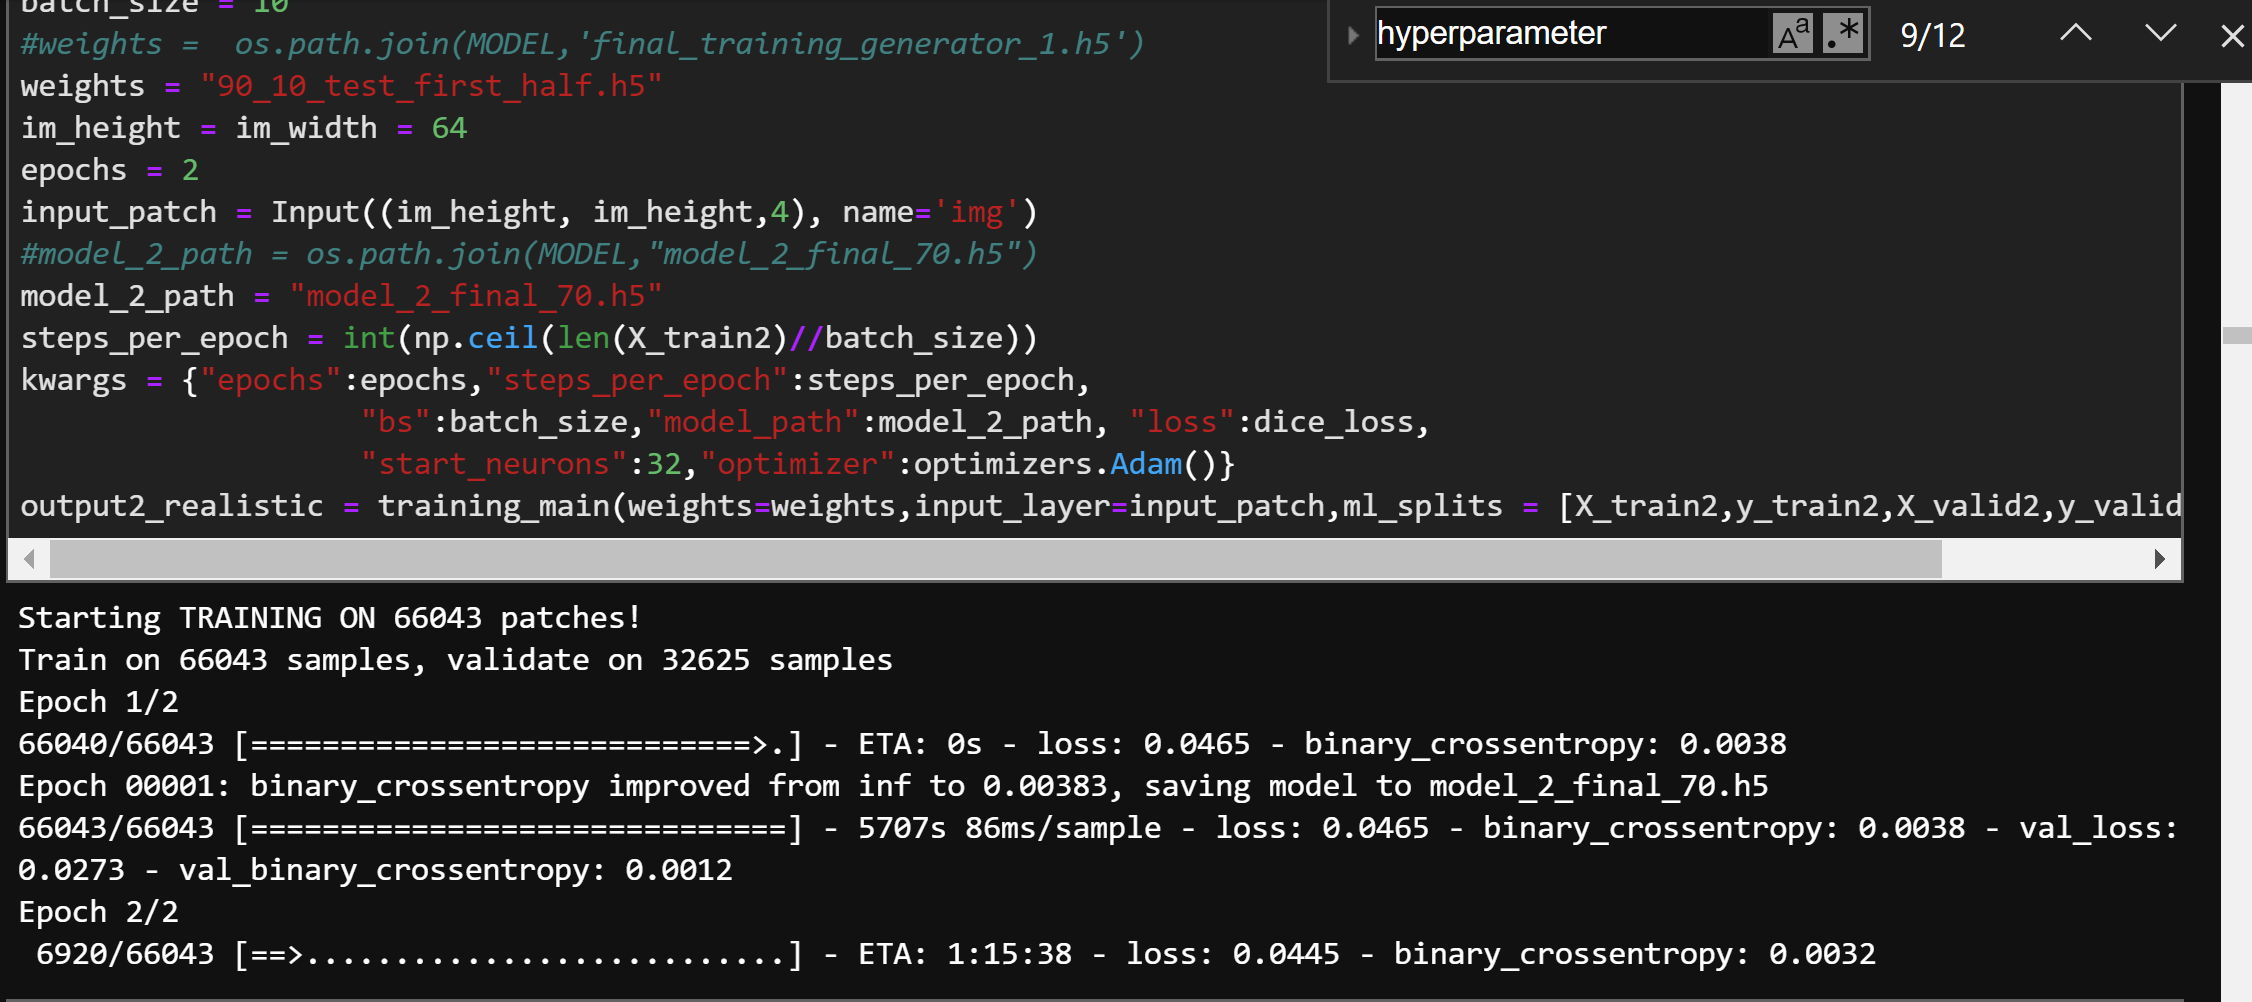

In [ ]:
#model_to_be_used_for_final_task = output2_realistic.get("model")

In [ ]:
# X_train_t, etc --- these are the TUMOR DATASETS!
# LAST LOSS OPTION : BIN CROSS ENTROPY + DICE LOSS
# we see that
# 30% of HEALTHYS (data1) in TRAINING---> on full data where there are 46% tumors, we get [0.5463906633469366, 112934.84]
# 10% of HEALTHYS (data2 in TRAINING ----> on full data where there are 46% tumors, we get [0.5355254359399119, 44757.594]


775/775 [==============================] - ETA: 2:59 - loss: 0.6533 - binary_crossentropy: 57758.515 - ETA: 2:49 - loss: 0.4922 - binary_crossentropy: 39011.007 - ETA: 2:41 - loss: 0.4054 - binary_crossentropy: 30788.021 - ETA: 2:34 - loss: 0.4060 - binary_crossentropy: 30309.576 - ETA: 2:30 - loss: 0.5139 - binary_crossentropy: 45893.730 - ETA: 2:21 - loss: 0.5449 - binary_crossentropy: 48173.550 - ETA: 2:13 - loss: 0.5294 - binary_crossentropy: 44076.875 - ETA: 2:05 - loss: 0.5007 - binary_crossentropy: 39716.097 - ETA: 1:57 - loss: 0.4988 - binary_crossentropy: 38491.582 - ETA: 1:49 - loss: 0.5432 - binary_crossentropy: 45226.925 - ETA: 1:41 - loss: 0.5522 - binary_crossentropy: 45837.621 - ETA: 1:33 - loss: 0.5425 - binary_crossentropy: 43444.949 - ETA: 1:25 - loss: 0.5241 - binary_crossentropy: 40841.043 - ETA: 1:18 - loss: 0.5244 - binary_crossentropy: 40346.070 - ETA: 1:10 - loss: 0.5447 - binary_crossentropy: 43523.023 - ETA: 1:02 - loss: 0.5431 - binary_crossentropy: 43670.320

[0.5355254359399119, 44757.594]

Here we see the results. Without a longer thought, the results might seem counterintuitive, namely:
**model that was trained on batch where 90% of them have tumor masks got a higher performance on data where there  only 46% of image slices have tumors**. For that reason, we train the U-Net first on 90%-tumor data followed by which we do the fine-tuning on 70-30 ratio.

### What if We Used Only Patches that Have Tumor Masks?


Ahaaa! This means  that when we use only tumor features, that means that their area would dominate and the network starts to predict all pixels as mask as the baseline since the loss function doesn't penalize predicting the tumor! Let's see if the models trained on 90% and 70% of tumors also got stuck in this local minimum:

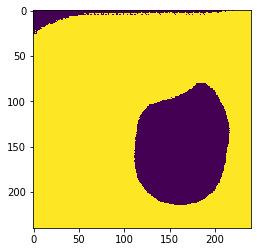

In [ ]:
#model_full.load_weights('generator_model_data2.h5')
#f2 = model_full.predict(all_features[0:5])
#vis(f2,4)


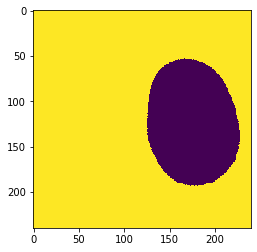

In [ ]:
#model_full.load_weights('generator_model_data1.h5')
#f1 = model_full.predict(all_features[0:5])
#vis(f1,2)


Since that indeed seems to be the possibility, we know it is up to the training procedure to sort it out where the balance should lie.

In [52]:
if "data_dictionary_first_half" in locals():
    del data_dictionary_first_half
if "data_dictionary_second_half" in locals():
    del data_dictionary_second_half
        


## Getting the Full Data Splits for Final Tuning

In [10]:
## FOR FINAL MODEL, WE TRAIN THE FULL MODEL ON THE 18 PATIENTS DATA AND VALIDATE ON 2 PATIENTS.
## NOTE THAT FOR FAIRNESS, THE VALIDATION PATIENTS SHOULD BE THE SAME AS BEFORE.
kwargs = {}
p = [1,2,3,4,5,6,7,8,9]
second_batch_training_patients = [10,11,12,13,14,15,16,17,18,19]
second_batch_testing_patients = [20]
patch_size=64
stride = patch_size//4
p.extend(second_batch_training_patients)
final_task_training= data_producer(custom_patients=p,need_patches=False,size_param = patch_size, stride_param=stride,slices=155,iftrain=1,**kwargs)
final_task_testing= data_producer(custom_patients=second_batch_testing_patients,need_patches=False,size_param = patch_size, stride_param=stride,slices=155,iftrain=1,**kwargs)
X_train3,y_train3 = final_task_training["all_features"],final_task_training["all_labels"]
print(final_task_training["all_labels"].shape)
X_valid3,y_valid3 = final_task_testing["all_features"],final_task_testing["all_labels"]
print(final_task_testing["all_features"].shape)

loading data from train folder
Patient number 1
Patient number 2
Patient number 3
Patient number 4
Patient number 5
Patient number 6
Patient number 7
Patient number 8
Patient number 9
Patient number 10
Patient number 11
Patient number 12
Patient number 13
Patient number 14
Patient number 15
Patient number 16
Patient number 17
Patient number 18
Patient number 19
(1273, 240, 240, 1)
(1273, 240, 240, 4)
loading data from train folder
Patient number 20
(85, 240, 240, 1)
(85, 240, 240, 4)
(2945, 240, 240, 1)
(155, 240, 240, 4)


# START FINAL MODEL FINE-TUNING HERE

### Now after Training on the full data for base task (task 1, we use these weights to do supervized fine-tuning on the main task)

In [12]:
input_patch = Input((240, 240,4), name='img')
model_final = build_model(input_patch, start_neurons=32) 
model_final.compile(optimizer=optimizers.Adam(), loss=dice_loss,metrics=["binary_crossentropy"])
model_final.load_weights("model_2_final_70_imp.h5")
print("Weights trained on the base task on all patients except 20 loaded!")

epochs = 3
callbacks2 = [
            EarlyStopping(patience=30, verbose=1),
            ReduceLROnPlateau(factor=0.05, patience=30, min_lr=0.00001, verbose=1),
            ModelCheckpoint('final_model_19_patients.h5', monitor='binary_crossentropy',verbose=1, 
                            save_best_only=True, save_weights_only=True)]

results_final = model_final.fit(X_train3, y_train3, batch_size=30, epochs=epochs, 
                            validation_data=(X_valid3, y_valid3),callbacks=callbacks2)
# spare weights are : 'model2_prefinal.h5' --- this is the one I reached before
#results_final.evaluate(all_features,all_labels,verbose=1) # see what this result comes first, that's what we're interested in!

Weights trained on the base task on all patients except 16 and 20 loaded!
Train on 2945 samples, validate on 155 samples
Epoch 1/3
2940/2945 [============================>.] - ETA: 4s - loss: 0.0115 - binary_crossentropy: 0.0045 
Epoch 00001: binary_crossentropy improved from inf to 0.00453, saving model to final_model_19_patients.h5
2945/2945 [==============================] - 2867s 974ms/sample - loss: 0.0114 - binary_crossentropy: 0.0045 - val_loss: 0.0245 - val_binary_crossentropy: 0.0010
Epoch 2/3
2940/2945 [============================>.] - ETA: 4s - loss: 0.0110 - binary_crossentropy: 0.0033 
Epoch 00002: binary_crossentropy improved from 0.00453 to 0.00334, saving model to final_model_19_patients.h5
2945/2945 [==============================] - 2870s 975ms/sample - loss: 0.0110 - binary_crossentropy: 0.0033 - val_loss: 0.0250 - val_binary_crossentropy: 0.0011
Epoch 3/3
  90/2945 [..............................] - ETA: 45:36 - loss: 0.0158 - binary_crossentropy: 7.8963e-04WARNING

KeyboardInterrupt: 

## Using the Fully Trained Model to GEnerate Test Predictions

In [63]:
## FIRST LET'S GET THE VALIDATION PREDICTIONS
#validationpredictions = model_final.predict(X_valid3,verbose=1)
#first_patient_predictions = model_final.predict(X_train3[0:155,:,:,:],verbose=1)
trainpredictions = model_final.predict(X_train3,verbose=1)
#d,b = data_dictionary.get("tumor_features"),data_dictionary.get("tumor_labels")
#print(d.shape)
#plot_predictions(trainpredictions)
#d1,b1 = tumor_filter(d,b)

2945/2945 [==============================] - 702s 238ms/sample


The challenge is to generate binary mask predictions because the round function is not differentiable and sigmoid activation outputs a probabilistic estimate for each target pixel. Since we do not wish to use gradient-free methods, the best way is to round the predictions after obtaining them from the model.

In [14]:
def zero_checker(data): 
    """Here we write a loop over all label_patches and save """
    df = np.zeros((len(data),1),dtype=np.int)
    for i in range(data.shape[0]):
        zerocheck = np.any(data[i,:,:,0]) # axis=(1, 2)
        if zerocheck == True:
            df[i]=1
        else :
            df[i]=0
    return df

def binary_shaper(predictions,threshold):
    test_masks = np.empty_like(predictions)
    test_masks[np.where( predictions > threshold )] = 1
    test_masks[np.where( predictions <= threshold )] = 0
    return test_masks

def prediction_checkup(model,labels,features=None,predictions = None,threshold=0):
    if predictions is None and features is not None:
        total_slices = features.shape[0]
        predictions = model.predict(features)
    elif predictions is not None:
        total_slices = predictions.shape[0]
    
    #print(f"Amount of total slices is {total_slices}")
    pred_array = np.asarray(predictions,dtype=np.float32)
    pred_binary = binary_shaper(pred_array,threshold)
    zero_checker_pred = zero_checker(pred_binary)
    zero_checker_label = zero_checker(labels)

    nonzero_slices_pred = np.sum(zero_checker_pred)
    nonzero_slices_label = np.sum(zero_checker_label)

   # print(f"Amount of nonzero slices in prdictions is {nonzero_slices_pred}")
    amount_of_zeroslices = total_slices-nonzero_slices_pred
    #print(f"Amount of zero slices in predictions is {amount_of_zeroslices}")
    return nonzero_slices_pred,nonzero_slices_label



### Choosing the Threshold. Since we can use the whole validation data and we know how many non-zero tumor batches there are, one quick way to set a feasible threshold for binary masking would be to match that number approximately.

### Selection of Model for Generating Test Predictions


In [ ]:
# in the trial experiments, the threshold was at around 3e-6, now 1e-5 could fit, so we can set it to their average
th = np.linspace(0,9e-5,10)
i=0
for threshold in th:
    nonzero_slices_pred,nonzero_slices_label = prediction_checkup(labels=y_valid3,model=model_final,predictions=validationpredictions,threshold=threshold)
    if i == 0:
        print(f"We have {nonzero_slices_label} nonzero slices in validation labels")
    print(f"For threshold {threshold} the amount of nonzero predictions is {nonzero_slices_pred}")
    i+=1
# we select the binary masking threshold to be 3e-6
#validationpred_masked=binary_shaper(predictions=validationpredictions,threshold=3e-6)


#### Choosing the Activation Threshold for the Model For Converting Masks to Binary
#### Validating that the Binary Thresholding Selection Makes Sense

In [ ]:
### FOR PATIENT 20, THE THRESHOLD SHOULD BE SOMEWHERE AROUND 1.1e-5
## FOR PATIENT 1,  1.33e-5
## FOR PATIENT 7,  1.7E-5
# for patient 13,  1.15e-5
# for patient 4, 1.11e-5
# for patient 10, 1.9e-5
# for patient 18, 1.3e-5
#### BASED ON THIS DATA, we will set the threshold to 1.4e-5. We will take  last 2 patients to validate that threshold.
# it was generated to be 15 and 17.
# based on validation data, the FINAL THRESHOLD IS SET TO 1.36e-5.
maxplots = 10
i = 0
th = np.linspace(9.9e-6,2e-5,10)
comparison_indices = np.random.randint(predictions.shape[0], size=(maxplots, 1))
for threshold in th: 
    print(f"THRESHOLD {threshold}")
    pred_masked=binary_shaper(predictions=predictions,threshold=threshold)
    fix, ax = plt.subplots(maxplots,2, figsize=(8,40))
    j = 0
    for idx in comparison_indices:
        ax[j,0].imshow(pred_masked[idx[0],:,:,0])
        ax[j,1].imshow(y_train3[16*155+idx[0],:,:,0])
        j += 1
    plt.show()  
    i+=1
plt.show()


In [ ]:
predictions = trainpredictions
maxplots = 50
comparison_indices = np.random.randint(predictions.shape[0], size=(maxplots, 1))
threshold = 1.37e-5
print(f"THRESHOLD {threshold}")
pred_masked=binary_shaper(predictions=predictions,threshold=threshold)
fix, ax = plt.subplots(maxplots,2, figsize=(8,40))
j = 0
for idx in comparison_indices:
    ax[j,0].imshow(pred_masked[idx[0],:,:,0])
    ax[j,1].imshow(y_train3[idx[0],:,:,0])
    j += 1

### Notes on Binary Mask Activation Threshold Selection

From the above results generated on random indices the activation threshold 1.37e-5 seems like a very good choice, as probably are many of the nearby values.
More analytical approach would be to actually assess the patient-wise average Dice coefficient on the validation set.

In [ ]:
    #pred_array,zeroslices,zero_checker_array = prediction_checkup(model=model_full,predictions=all_predictions,threshold=0.8)
#zeroslices

## Using the best Model to Generate Test Predictions

In [69]:
## FIRST WE USE THE DATA PRODUCER TO LOAD THE TEST FEATURES
data_dictionary_test = data_producer(custom_patients=None,startpatient=1,endpatient=10+1,need_patches=False,size_param = patch_size, stride_param=stride,slices=155,iftrain=0,**kwargs)
test_features = data_dictionary_test.get("all_features")
testpredictions = model_final.predict(test_features,verbose=1)
testpredictions_mask = binary_shaper(testpredictions,threshold=1.37e-5)

testpredictions_list = 10*[0]
for i in range(10):
    testpredictions_list[i] = testpredictions_mask[i*155:(i+1)*155,:,:,0]



loading data from test folder
Patient number 1
Patient number 2
Patient number 3
Patient number 4
Patient number 5
Patient number 6
Patient number 7
Patient number 8
Patient number 9
Patient number 10
1550/1550 [==============================] - 371s 239ms/sample


In [81]:
testpredictions_list[9].shape

(155, 240, 240)

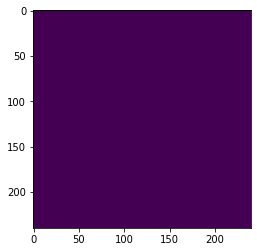

In [79]:
def savePickle(data, picklefile):
    """

    :param data: Data to be saved
    :param picklefile: Filename for output Pickle file, should have .pickle ending
    """
    import pickle
    with open(picklefile, "wb") as f:
        pickle.dump(data, f,protocol=4)
    f.close()

#savePickle(testpredictions_list,"testpredictions.pkl")
plt.imshow(testpredictions_list[0][154,:,:])

## We submit the testpredictions_list defined in the above cell as testpredictions to be evaluated

## HEREBY THE PREDICTION GENERATION PART IS OVER. FOLLOWING IS SOME EXTRA INFORMATION, THEORETICALLY AND OTHERWISE

# Hyperparameter Tuning Methodologies and Parameter Questions


I have considered the following:
    - 1. Prefer using Batch Normalization when considering Dropout, Batchnorm or Dropout + Batchnorm https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout
    - 2. In case of overfitting, would add kernel regularizers to convolution layers
    - 3. A good way to do hyperparameter tuning with Auto-Keras. To end up, we give a brief example how it could be used

In [ ]:

# Conv2D, Conv2DTranspose,concatenate,MaxPooling2D

class MyHyperModel(HyperModel):

    def __init__(self, start_neurons,img_size):
        self.start_neurons = start_neurons
        self.size = img_size
        

    def build(self,hp):
        def dice_loss(y_true,y_pred): 
             def dice_coef_2_lean(y_true, y_pred, smooth=K.epsilon()):
                """
                Dice = (2*|X & Y|)/ (|X|+ |Y|)
                     =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
                ref: https://arxiv.org/pdf/1606.04797v1.pdf
                """
                intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
                denominator = K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth
                return (2. * intersection + smooth) / denominator

             return 1-dice_coef_2_lean(y_true, y_pred)
            
            
        
        # https://arxiv.org/pdf/1603.06560.pdf
        input_layer = tf.keras.Input(shape=(self.size, self.size, 4))
        # tweak initializer and kernel
        # no need to use dropout : https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout
        #     model_type = hp.Choice('model_type', ['random_forest', 'ridge'])
        # kernels, dropouts, batchnorm, activation functions
        # DEFINE INPUT LAYER WITH START NEURONS
        # ADD KERNEL REGULARIZATION DEFINITELY
        # IN CASE OF OVERFITTING, START TO ADD REGULARIZERS regularizers.l2(0.00001)
        conv1 = Conv2D( self.start_neurons * 1, (3, 3), kernel_initializer="he_normal", padding="same")(input_layer)
        conv1 = BatchNormalization()(conv1)
        conv1 = Conv2D( self.start_neurons * 1, (3, 3), kernel_initializer="he_normal",padding="same")(conv1)
        conv1 = BatchNormalization()(conv1)
        pool1 = MaxPooling2D((2, 2))(conv1)
        #pool1 = Dropout(hp.Float('drop1', 0.1, 0.25,0.5))(pool1)

        conv2 = Conv2D( self.start_neurons * 2, (3, 3), kernel_initializer="he_normal", padding="same")(pool1)
        conv2 = BatchNormalization()(conv2)
        conv2 = Conv2D( self.start_neurons * 2, (3, 3), kernel_initializer="he_normal", padding="same")(conv2)
        conv2 = BatchNormalization()(conv2)
        pool2 = MaxPooling2D((2, 2))(conv2)
        #pool2 = Dropout(hp.Float('drop2', 0.1, 0.25,0.5))(pool2)

        conv3 = Conv2D( self.start_neurons * 4, (3, 3), kernel_initializer="he_normal", padding="same")(pool2)
        conv3 = BatchNormalization()(conv3)
        conv3 = Conv2D( self.start_neurons * 4, (3, 3), kernel_initializer="he_normal", padding="same")(conv3)
        conv3 = BatchNormalization()(conv3)
        pool3 = MaxPooling2D((2, 2))(conv3)
        #pool3 = Dropout(hp.Float('drop3', 0.1, 0.25,0.5))(pool3)

        conv4 = Conv2D( self.start_neurons * 8, (3, 3), kernel_initializer="he_normal",  padding="same")(pool3)
        conv4 = BatchNormalization()(conv4)
        conv4 = Conv2D( self.start_neurons * 8, (3, 3), kernel_initializer="he_normal", padding="same")(conv4)
        conv4 = BatchNormalization()(conv4)

        pool4 = MaxPooling2D((2, 2))(conv4)
        #pool4 = Dropout(hp.Float('drop4', 0.1, 0.25,0.5))(pool4)


        # Middle
        convm = Conv2D( self.start_neurons * 16, (3, 3), kernel_initializer="he_normal", padding="same")(pool4)
        convm = BatchNormalization()(convm)
        convm = Conv2D( self.start_neurons * 16, (3, 3), kernel_initializer="he_normal", padding="same")(convm)
        convm = BatchNormalization()(convm)

        deconv4 = Conv2DTranspose( self.start_neurons * 8, (3, 3), kernel_initializer="he_normal", strides=(2, 2), padding="same")(convm)
        uconv4 = concatenate([deconv4, conv4])
        #uconv4 = Dropout(hp.Float('drop5', 0.1, 0.25,0.5))(uconv4)
        uconv4 = Conv2D( self.start_neurons * 8, (3, 3), kernel_initializer="he_normal", padding="same")(uconv4)
        uconv4 = BatchNormalization()(uconv4)
        uconv4 = Conv2D( self.start_neurons * 8, (3, 3), kernel_initializer="he_normal", padding="same")(uconv4)
        uconv4 = BatchNormalization()(uconv4)

        deconv3 = Conv2DTranspose( self.start_neurons * 4, (3, 3), kernel_initializer="he_normal",strides=(2, 2), padding="same")(uconv4)
        uconv3 = concatenate([deconv3, conv3])
        #uconv3 = Dropout(hp.Float('drop6', 0.1, 0.25,0.5))(uconv3)
        uconv3 = Conv2D( self.start_neurons * 4, (3, 3), kernel_initializer="he_normal", padding="same")(uconv3)
        uconv3 = BatchNormalization()(uconv3)
        uconv3 = Conv2D( self.start_neurons * 4, (3, 3), kernel_initializer="he_normal", padding="same")(uconv3)
        uconv3 = BatchNormalization()(uconv3)

        deconv2 = Conv2DTranspose( self.start_neurons * 2, (3, 3), kernel_initializer="he_normal", strides=(2, 2), padding="same")(uconv3)
        uconv2 = concatenate([deconv2, conv2])
        #uconv2 = Dropout(hp.Float('drop7', 0.1, 0.25,0.5))(uconv2)
        uconv2 = Conv2D( self.start_neurons * 2, (3, 3),  kernel_initializer="he_normal",padding="same")(uconv2)
        uconv2 = BatchNormalization()(uconv2)
        uconv2 = Conv2D( self.start_neurons * 2, (3, 3), kernel_initializer="he_normal", padding="same")(uconv2)
        uconv2 = BatchNormalization()(uconv2)

        deconv1 = Conv2DTranspose( self.start_neurons * 1, (3, 3),kernel_initializer="he_normal", strides=(2, 2), padding="same")(uconv2)
        uconv1 = concatenate([deconv1, conv1])
        #uconv1 = Dropout(hp.Float('drop8', 0.1, 0.25,0.5))(uconv1)
        uconv1 = Conv2D( self.start_neurons * 1, (3, 3), kernel_initializer="he_normal", padding="same")(uconv1)
        uconv1 = BatchNormalization()(uconv1)
        uconv1 = Conv2D( self.start_neurons * 1, (3, 3), kernel_initializer="he_normal",padding="same")(uconv1)
        uconv1 = BatchNormalization()(uconv1)

        output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
        model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Choice('learning_rate',
                          values=[1e-2, 1e-3, 1e-4])),
            loss=dice_loss,
            metrics=["binary_crossentropy"])
        return model


hypermodel = MyHyperModel(start_neurons=32,img_size=240)

tuner = kt.Hyperband(
    hypermodel.build,
    objective= kt.Objective("val_loss", direction="min"),
    max_epochs=100,
    hyperband_iterations=2)



INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


## Configuring the Data For Full Experiment

In [ ]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

def dice_loss(y_true,y_pred): 
     def dice_coef_2_lean(y_true, y_pred, smooth=K.epsilon()):
        """
        Dice = (2*|X & Y|)/ (|X|+ |Y|)
             =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
        ref: https://arxiv.org/pdf/1606.04797v1.pdf
        """
        intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
        denominator = K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth
        return (2. * intersection + smooth) / denominator

     return 1-dice_coef_2_lean(y_true, y_pred)
    
def data_comparison_experiment(epochs,mode,hypermodel,tuner,X_train_tumor,y_train_tumor,X_train,y_train,X_valid,y_valid):
    
    if mode == "hyperparam_tuning":
        tuner.search(X_train_tumor,y_train_tumor,
                     epochs=5,
                     validation_data=val)
        best_model_1 = tuner.get_best_models(1)[0]
        best_hyperparameters_1 = tuner.get_best_hyperparameters(1)[0].values

        best_model_1.save_weights("model1.h5")
        print(tuner.search_space_summary())
        tuner.search(tr2[0],tr2[1],
                     epochs=5,
                     validation_data=val)
        best_model_2 = tuner.get_best_models(1)[0]
        best_hyperparameters_2 = tuner.get_best_hyperparameters(1)[0].values
        best_model_2.save_weights("model2.h5")
        print(tuner.search_space_summary())
    elif mode == "testing_data":
        im_height = im_width = 240
        batch_size = 15 # set the batch size so that the Learner never mixes data from different patients together!
        #input_img = Input((im_height, im_width,4), name='img')
        input_img = tensorflow.keras.Input(shape=(240, 240, 4))

        model = build_model(input_img, start_neurons=32) # , dropout=0.05, batchnorm=True
        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=dice_loss,
            metrics=["binary_crossentropy"])
            
        callbacks = [
            EarlyStopping(patience=10, verbose=1),
            ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
            ModelCheckpoint('model1_prefinal', monitor='binary_crossentropy',verbose=1, 
                            save_best_only=True, save_weights_only=True),
            LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)
        ]
        
        results1 = model.fit(X_train_tumor, y_train_tumor, batch_size=batch_size, epochs=epochs, callbacks=callbacks,\
                            validation_data=(X_valid, y_valid))
        
        results2 = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks,\
                            validation_data=(X_valid, y_valid))
        
        out = {"res_1":results1,"res_2":results2,"model1":model1,"model2":model}
        # FROM HERE, WE CAN SAVE THE BEST PERFORMING MODEL, WITH SMALLEST DICE LOSS
    #dice_1=best_model_1.evaluate(X_valid[test_idx],y_valid[test_idx],verbose=2)[0]
    #dice_2 = best_model_2.evaluate(X_valid[test_idx],y_valid[test_idx],verbose=2)[0]
    
    return out # {"dice_1":dice_1,"dice_2":dice_2}


    
hypermodel = MyHyperModel(start_neurons=32,img_size=240)

tuner = kt.Hyperband(
    hypermodel.build,
    objective= kt.Objective("val_loss", direction="min"),
    max_epochs=100,
    hyperband_iterations=2,)

#tuner.search(tr1[0],tr1[1],epochs=5,validation_data=val)

#comparison_result = data_comparison_experiment(hypermodel,tuner,tr1,tr2,val,X_valid,y_valid,test_idx)

#oracle=kt.oracles.BayesianOptimization(
#            objective=kt.Objective('score', 'max'),
#            max_trials=10)



Physical devices cannot be modified after being initialized
INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
#import tensorflow
#out = data_comparison_experiment(15,"testing_data",hypermodel,tuner,X_train_tumor,y_train_tumor,X_train,y_train,X_valid,y_valid)

#!rm -rf ./untitled_project/

In [ ]:
#only_tumor_results2
valpredictions = only_tumor.predict(X_valid,verbose=1)
trainpredictions = only_tumor.predict(X_train_tumor,verbose=1)

1087/1087 [==============================] - 14s 13ms/step


## Some Results Without  Using the Patching Technique : 
### FROM Experiments Using Only Tumors in the  Training Set, 3 epochs

1. Using Dice Loss
1.1 SGD :  SGD momentum=0.3, nesterov=True). Quite bad Dice Loss, predicting only tumors, thus very little overlap
![image.png](attachment:image.png)
1.2 Adam loss: 0.9786 - binary_crossentropy: 15.6108  , even worse Dice loss (0.9783, predicting only tumors)


These results show that using only tumor in the training can easily lead to a situation where only tumors are predicted with very bad Dice loss or only blank images are predicted with no masks. To get to a target with good Dice loss that can also find some tumors, we should have a dataset using random augmentations on the data plus the training set balance is similar to the whole datasetw --  if 43.8% of the labels actually have tumor masks, then this ratio should be ideally around the same in the training dataset.


Problem with using reduced datasets is that it changes the true distribution of the data and at testing time, this will skew the testing result.

## Choice of Loss Function : Dice Loss VS Combined Loss



Binary Cross-Entropy returns a tensor, while  Dice Loss returns a scalar for each image in the batch. If we combined these, we could combine local with global information.

__Practice__ : In practice I have seen that usually when Dice Loss goes down close to the last phases in training, the binary cross-entropy will also. In the very last phases binary-cross entropy will be 0 all the time, so we figure that it's not utmost necessary to combine the losses. We can easily train with the Dice Loss since for the ones with squares, the gradient is well-defined.

# Theoretical Considerations for Architecture
Subsequently, the U-Net architecture was extended through a few modifications to 3D
U-Net for volumetric segmentation [28]. In particular, the two dimensional convolution,
max pooling, transposed convolution operations were replaced by their three dimensional
counterparts. However, in order to limit the number of parameters, the depth of the
network was reduced by one. Moreover, the number of filters were doubled before the
pooling layers to avoid bottlenecks [34]. The original U-Net [24] did not use batch normalization [35], however, they were experimented with in the 3D U-Net and astonishingly
the results revealed that batch normalization may sometime even hurt the performance
[28].

https://arxiv.org/pdf/1902.04049.pdf


In medical image segmentation, we are interested in segmenting cell necluei [36], organs
[4], tumors [3] etc. from images originating from various modalities. However, in most
cases these objects of interest are of irregular and different scales. For example, in Figure
2 we have demonstrated that the scale of skin lesions can greatly vary in dermoscopy
images. These situations frequently occur in different types medical image segmentation
tasks.
(a) (b) (c)
Figure 2: Variation of Scale in medical images. Fig. 2a, 2b, 2c are examples of dermoscopy images with
small, medium and large size of lesions respectively. The images have been taken from the ISIC-2018
dataset.
Therefore, a network should be robust enough to analyze objects at different scales.
Although this issue has been addressed in several deep computer vision works, to the best
of our knowledge, this issue is still not addressed properly in the domain of medical image
segmentation. 
In the U-Net architecture, after each pooling layer and transposed convolutional layer
a sequence of two 3 × 3 convolutional layers are used. As explained in [34], this series
of two 3 × 3 convolutional operation actually resembles a 5 × 5 convolutional operation.
Therefore, following the approach of **Inception network, the simplest way to augment
U-Net with multi-resolutional analysis is to incorporate 3 × 3, and 7 × 7 convolution
operations in parallel to the 5 × 5 convolution operation**, as shown in Figure 3a.
Therefore, replacing the convolutional layers with Inception-like blocks should facilitate the U-Net architecture to reconcile the features learnt from the image at different
scales. 

Another possible option is to use strided convolutions [38], but in our experiments it was overshadowed by U-Net using Inception-like blocks. Despite the gain in
performance, the introduction of additional convolutional layers in parallel extravagantly increases the memory requirement. 

### 2D VS 3D Considerations
https://arxiv.org/pdf/1908.05104.pdf

The study of CNN is mainly based on two  
dimensional (2D) and three-dimensional (3D) approaches:
(1) In the 2D CNN approaches, the MRI volume data are
converted into several planar slices and independently predict the lesion area of each slice. These ignore the spatial
characteristics of the MRI data such that the predictions
are discontinuous. (2) In the 3D CNN, approaches, spatial
information is extracted for inference. However, due to their
computational and storage requirements, the 3D CNN have
been largely avoided.

Architectures considered:
    - SegNet
    - UNet3D
    - Unet Origin
    - D-Unet
    
On a first glance, D-Unet seems to match the description well since we can append to architecture,
but actually not because of     conv2 = D_SE_Add(64, conv3d2, conv2) is modifying the architecture

<br/>
<img src="https://drive.google.com/uc?id=1PimNuQYd_c188kEvReMdnr2UtF3xQqpm" style="width: 900px;"/>
<br/>

Now if we look closely the required architecture, input has to be 4-dimensional and output 1-dimensional.
Since U-NET is not using 3D-convolutions, it does not make sense to have all slices input to the network in a batch, thus, the 4-dimensional input refers to the fact of having 4 channels -- one for each MRI modality. In a classical machine learning sense, one modality becomes one "rudimentary" feature.

## D-Unet : Changes the Scheme

In [ ]:
def Unet():
    inputs = Input(shape=(240, 240, 4))
    conv1 = BN_block(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = BN_block(64, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = BN_block(128, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = BN_block(256, pool3)
    drop4 = Dropout(0.3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = BN_block(512, pool4)
    drop5 = Dropout(0.3)(conv5)

    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = Concatenate()([drop4, up6])
    conv6 = BN_block(256, merge6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = Concatenate()([conv3, up7])
    conv7 = BN_block(128, merge7)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = Concatenate()([conv2, up8])
    conv8 = BN_block(64, merge8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = Concatenate()([conv1, up9])
    conv9 = BN_block(32, merge9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)  # conv10作为输出

    model = Model(input=inputs, output=conv10)

    return model

## Hyperparameter Tuning Strategies

Bayes SMBO is probably the best candidate as long as resources are not a constraint for you or your team, but you should also consider establishing a baseline with Random Search.

On the other hand, if you're still learning or in the development phase, then babysitting – even if unpractical in term of space exploration – is the way to go.

Just like I mentioned in the SMBO section, none of these strategies provide a mechanism to save our resources if a training is performing poorly or even worse diverging – we'll have to wait until the end of the computation.

### Machine Learning Approach : Conceptual Side

### SAMPLING STRATEGY

For network to learn anything, we have to feed the network proper data to learn from.
That means that we will subsample the input data to only use data in certain ratios and then we compare those ratios 1 (tumor) VS 0 (no tumor)
    1) ratio 56-44 (as in the dataset available)
    2) ratio 70-30 (more tumors, less healthys)
    3) ratio 30-70 (more healhtys, less tumors)
    
Keep in mind that the final ratio is assumed to be close to 56 - 44.
Within these ratios, we will do image patching and subsampling.

#### TWO APPROACHES : 

##### Imaginary approach 1 : Balancing Data Using Simple Logic
If we feed network 56% images having tumors and 44% corresponding to healthy ones, the network will most probably learn to predict blank images because the area of the tumors is up to a few orders of magnitude smaller than the healthy area even on the tumor image, and that is especially so because the tumor areas often don't overlap so the prediction from one set of tumor images would not generalize to other tumor images.

Since the network will be measured in terms of Dice index that measures pixel-wise similarity between the prediction and target images, we should keep this in mind also in the feature engineering phase since most of the similarity match will be due to the background match, not the tumor mask match! That means that although 56% of images have tumors, since the average tumor covers maybe 1/20 of the image area, relatively we have imbalance around 1/20 in favour for black pixels where the network would not learn essentially anything; moreover, the network would learn NOT TO LEARN and gradients would not change. Thus a split of 56-44 would not itself be sufficient.

##### Imaginary approach 2 : Balancing Data with Sampling
We need predictions that can be generalized.
As in any machine learning problem with imbalanced data set, binary classification with imbalanced dataset starts with upsampling like SMote or downsampling -- to balance the classes.
In this case, the low level unit can be engineered to be an image patch both on feature level and target level.

To accomplish that, we take the whole data and create patches from the labels where 1/2 of the patches have no tumor and the other half has. This is easy to do since we don't really care in the end from which patient the data originates as long as the network learns to predict tumors properly with good Dice index. We can create an artificial meta dataset like this

| Patch number | Tumor Indicator (1 for tumor, 0 for healthy)|
 
After we have done this for the whole dataset, then to have realistic scenario for the prediction, we would want the distribution tumor patches to healthy patches be 56-44 BEFORE train-test split.

To compare the approaches, we will consider the split ratio as a hyperparameter that we will tune with Auto-Keras.

Combinations that will be tried out:

- 30-70
- 90-10

After that, train-test split will be done and the network will be trained on the patches of data.

Totally alternative approach would be probably be to come up with some  exotic loss function that penalizes the network predicting 0 much more than predicting 1 - thus making the network essentially set really high sensitivity to the positive or tumor class.

This approach is more more theoretically backed : Deep learning learns to detect features from data, but if the data doesn't quantify variation if the variation in the data is very small, it cannot learn since it is essentially forced to not to learn. The network will do what the human master supervises.

#### Important Note
It is essential not to mechanically throw away any data, meaning not to **filter** out data that doesn't correspond to tumor in the labels. That also throws away useful variation from the feature set.
Instead we do the filtering on the batch level to get a more fine-grain grid.
Since the Task Assignment indicates that input has to be 4-dimensional, it is natural to use the already existing 4 features from different scans.

### Analysis of How the Network Could Perform
Now we have trained a network only on the tumor images. The idea here is that since the tumor masks are very small, 
then wihtout actually using the real life weights ( not detecting a brain tumor in real life has really high cost), mathematically speaking there is no problem predicting the tumor mask sometimes when in the real sample there was no tumor PROVIDED the relative tumor mask area is orders of magnitude smaller than the non-tumor area. If we only account for the Dice coefficient, then most of the area would still be correctly predicted.
This idea can be compared to the F1-score where instead of the intersection we have precision x recall.
The more fundamental problem is that this kind of a model that have a decently good Dice loss but always predicts background image instead of the mask is not at all useful and no compute resources should be spent on that! Also the assignment informed us to develop a generalizing model, otherwise we could just predict blank images all the way.

### Approach Summarized
1. Dividing data loading into two due to memory considerations.
2. For first 9 patients, we generate patches for features and Labels and use all the data there. Alternatively could use only mostly tumor data since then there is something more essential for the network to learn from. We split all the batches in the ratio 80-20, 20 to check for the validation error and to see if the model is performing all right.
For the rest of the 11 patients, we do batching patient-wise since the final evaluation is also done patient-wise. For that we generate 9 random integers without replacement for training and 2 for validation. No train-test split function is used, instead we subset the training set to match the ratio 70-30 (tumors vs non-tumors) as this showed promise in the testing rounds and then we test on non-altered batches of the remaining 2 patients to get as genuine representation of the generalization error.

3. Transfer Learning with U-Nets with the (differentiable, with squares and smoothing addition) Dice Loss as the loss function. So basically the transfer learning in this context means that we are first making sure the network actually learns anything by providing it the feature and label patches of data. After the network has learned from these small batches of data to predict more or less adequate mask shapes, we load these weights into the U-NET for the initial problem and fine-tune that. Finally after finetuning, we use that to generate test predictions.
4. Lastly I would do  hyperparameter tuning with Auto-Keras where the individual strategies would be optimizations over datasets and hyperparameters. Not included in this submission yet.

# Alterative Approach and Possible Additions
## Image Reconstructions
We could have directly tried to reconstruct the initial task masks from the predictions obtained from the learner trained on the feature patches. In principle it works this way that after extracting the patches, we use the learned to predict patches of the original masks. Then we do the inverse mapping from these predictions to the original labels. This can be done also in Tensorflow since there are some useful relations about the mapping.

## Augmentations
We tried out Keras ImageDataGenerator augmentations that add transformations to the underlying data randomly. We checked that on small datasets, training didn't actually benefit from these neither on the patched data nor in the original data. It might be because of the data imbalance as well as the parameter choices for augmentations. There are also other libraries that could be tried out for example `Albumentations`.


### Alternative Approach -- Direct Reconstruction of Tumor Masks from Patch Predictions

We didn't pursue this approach due to some technical inconsistencies, but theoretically this approach should also work.

In [ ]:
# patch_size=64
# stride = patch_size//4
# strides = [1,stride,stride,1]
# sizes = [1,patch_size,patch_size,1]
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()
# 
# def extract_patches(x,sizes,strides):
#     return image.extract_patches(
#         x,
#         sizes,
#         strides,
#         (1, 1, 1, 1),
#         padding="SAME"
#     )
# 
# def extract_patches_inverse(x, y,sizes,strides):
#     _x = tensorflow.zeros_like(x)
#     _y = extract_patches(_x,sizes,strides)
#     grad = tensorflow.gradients(_y, _x)[0]
#     # Divide by grad, to "average" together the overlapping patches
#     # otherwise they would simply sum up
#     return tensorflow.gradients(_y, _x, grad_ys=y)[0] / grad
# 
# # Extract patches
# #patches = extract_patches(images)
# # Reconstruct image
# # Notice that original images are only passed to infer the right shape
# all_labels = data_dictionary_2_patients_test.get("all_labels")
# #reshaped_mask_predictions = two_patients_predicted_masks.reshape(-1, patch_size, patch_size, 1)
# #print(reshaped_mask_predictions.shape)
# images_reconstructed = extract_patches_inverse(all_labels, reshaped_mask_predictions,sizes,strides) 
# 

## Attempting to write Patient-wise Average Dice Loss

In [ ]:
#def average_dice_loss(threshold=0.01,labels=np.asarray(all_labels,dtype=np.float32),predictions = np.asarray(all_predictions,dtype=np.float32)):
#    amount_of_patients = labels.shape[0]//155
#    #losses = np.zeros((amount_of_patients,1))
#    predictions_binary = binary_shaper(predictions,threshold)
#    
#    losses = []
#    for i in range(amount_of_patients):
#        patient_i_labels = labels[i*155:(i+1)*155,:,:,0]
#        patient_i_predictions = predictions_binary[i*155:(i+1)*155,:,:,0]
#        print(patient_i_predictions.shape)
#        randi = np.random.randint(low=0,high=155,size=1)[0]
#        print("PREDICTION IS:")
#        plt.imshow(patient_i_predictions[randi,:,:])
#        plt.show()
#        print("TRUE LABEL IS")
#        plt.imshow(patient_i_labels[randi,:,:])
#        plt.show()
#        ith_loss = dice_loss(y_true=patient_i_labels.flatten(),y_pred=patient_i_predictions.flatten())
#        print(f"ith patient loss is {ith_loss}")
#        #losses[i]=ith_loss
#        losses.append(ith_loss)
#        current_average = np.mean(losses)
#        print(f"Current running average of losses is {current_average}")
#    
#    return np.mean(losses)

#a = average_dice_loss(threshold=0.1)
#print(f"The average patient-wise Dice loss is {a}")